# Import

In [14]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt # Visualisation
import seaborn as sns          
import plotly.express as px
import plotly.io as pio

%matplotlib inline

!conda install -c conda-forge -y lifelines
!conda install -c conda-forge -y scikit-learn

from itertools import product
from lifelines import KaplanMeierFitter
from collections import Counter

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RepeatedKFold, RepeatedStratifiedKFold, cross_val_score, cross_validate
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import GridSearchCV, HalvingGridSearchCV, cross_val_predict
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.inspection import permutation_importance
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc, RocCurveDisplay

from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
import shap


zsh:1: command not found: conda
zsh:1: command not found: conda


In [15]:
data = pd.read_csv('heart_failure_clinical_records_dataset.csv')
df = pd.DataFrame(data)
df

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,61,1,38,1,155000.00,1.1,143,1,1,270,0
295,55.0,0,1820,0,38,0,270000.00,1.2,139,0,0,271,0
296,45.0,0,2060,1,60,0,742000.00,0.8,138,0,0,278,0
297,45.0,0,2413,0,38,0,140000.00,1.4,140,1,1,280,0


# EDA

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   age                       299 non-null    float64
 1   anaemia                   299 non-null    int64  
 2   creatinine_phosphokinase  299 non-null    int64  
 3   diabetes                  299 non-null    int64  
 4   ejection_fraction         299 non-null    int64  
 5   high_blood_pressure       299 non-null    int64  
 6   platelets                 299 non-null    float64
 7   serum_creatinine          299 non-null    float64
 8   serum_sodium              299 non-null    int64  
 9   sex                       299 non-null    int64  
 10  smoking                   299 non-null    int64  
 11  time                      299 non-null    int64  
 12  DEATH_EVENT               299 non-null    int64  
dtypes: float64(3), int64(10)
memory usage: 30.5 KB


In [27]:
df = df.rename(columns={"DEATH_EVENT": "died"})

In [28]:
categorical_cols = df.loc(axis=1)['anaemia','diabetes','high_blood_pressure','sex','smoking','died']
numerical_cols = df.loc(axis=1)['age','creatinine_phosphokinase','ejection_fraction','platelets','serum_creatinine','serum_sodium','time']

## Categorical Columns

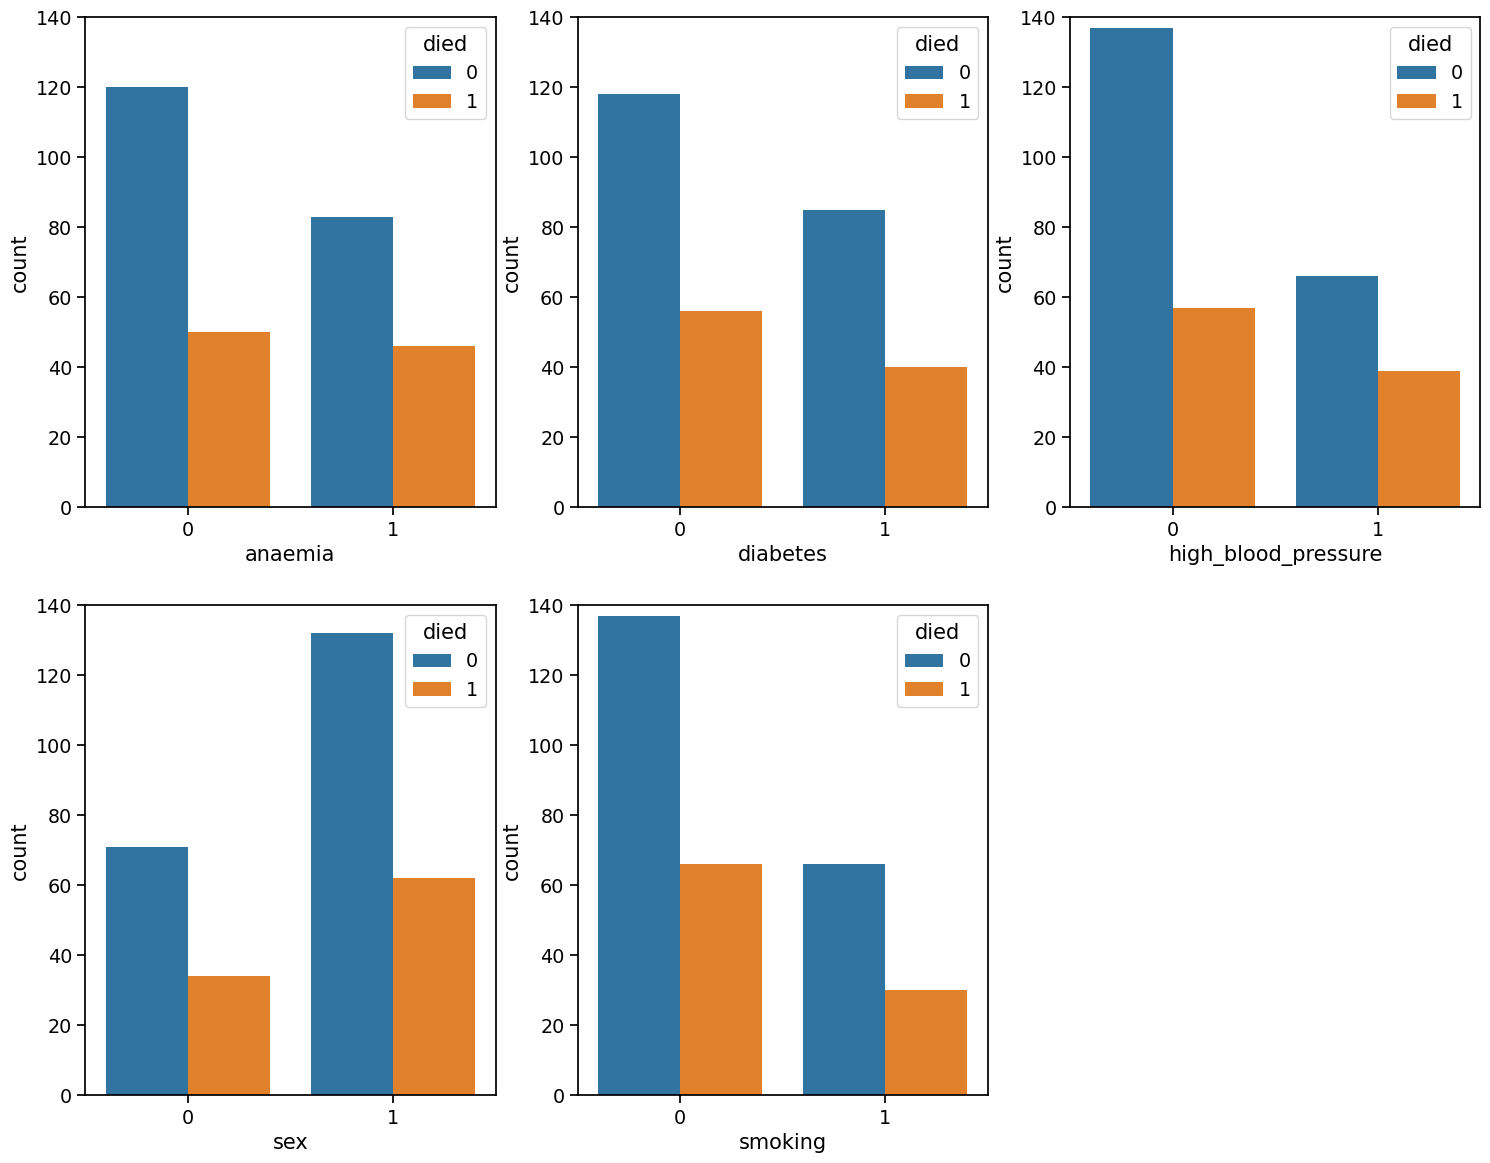

In [29]:
sns.set_context("notebook", font_scale=1.25)

fig, ax = plt.subplots(2,3, figsize=(18,14))
[sns.countplot(data=df, x=cat, hue="died", ax=ax.flatten()[i]) 
 for i,cat in enumerate(categorical_cols.drop('died',axis=1))]
ax.flatten()[-1].set_visible(False) # Remove the 6th empty plot
[y_ax.set_ylim(0,140) for y_ax in ax.flatten()]
plt.show()

In [30]:
seaborn_cols = ['#3f75a0', '#d88138']
fig = px.parallel_categories(categorical_cols, color="died", color_continuous_scale=seaborn_cols)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

**The parallel coordinates plot below is scary at first but it is an extremely efficient way to interrogate a lot of data. It shows the distribution of continuous variables, and the interactivity allows for many questions to be qualitatively answered easily, i.e. what is the outcome for those with age>90? And difference in outcome between genders? etc.**

In [31]:
fig = px.parallel_coordinates(df, color="died", color_continuous_scale=seaborn_cols)
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

## __Numerical columns__

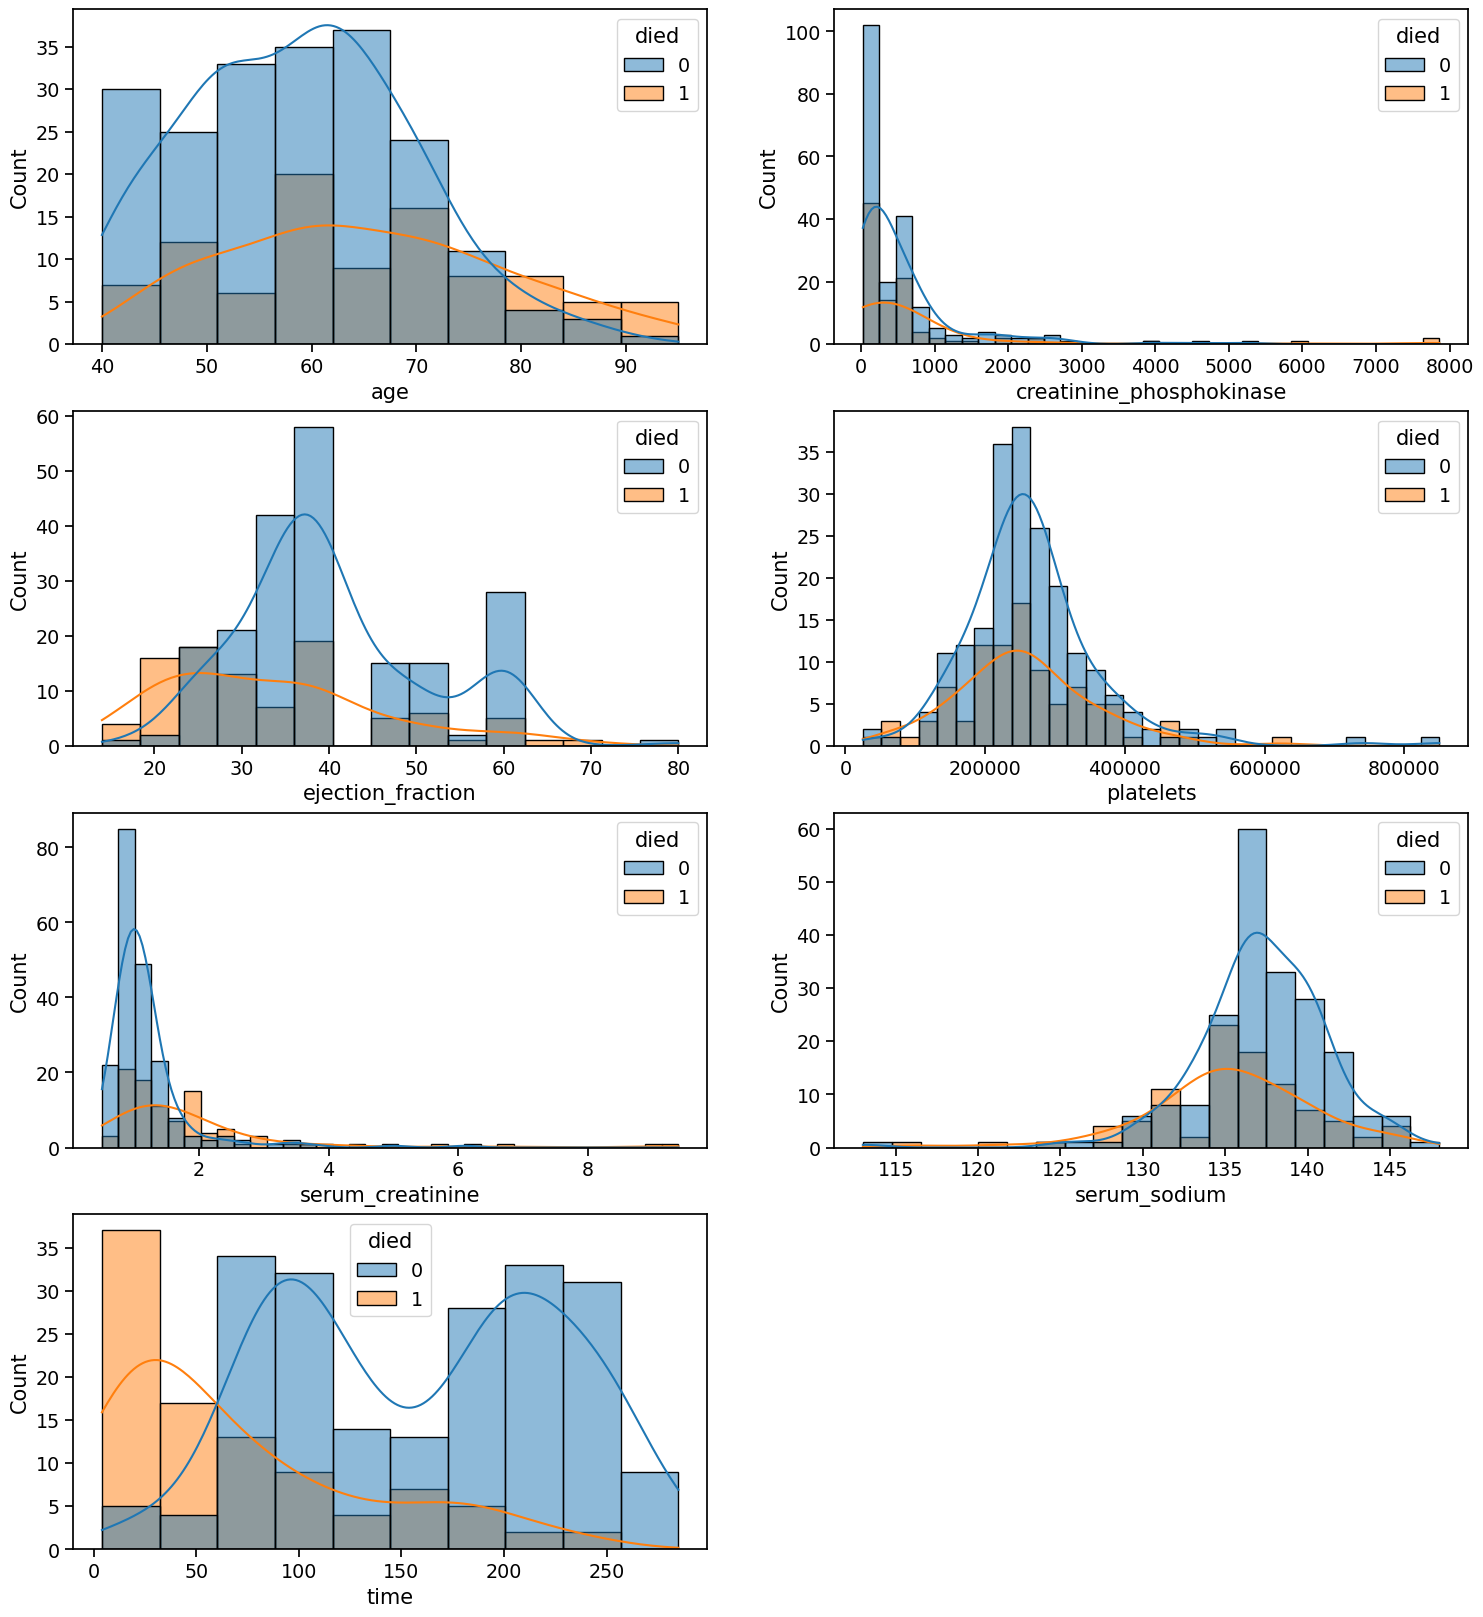

In [32]:
fig, ax = plt.subplots(nrows=4, ncols=2, figsize=(18,20))
[sns.histplot(data=df, x=num, hue="died", kde=True, ax=ax.flatten()[i]) for i,num in enumerate(numerical_cols)]
ax.flatten()[-1].set_visible(False)
plt.show()

## Survival Analysis using Kaplan-Meier plots<br>
 First we need a function that will allow us to quickly plot Kaplan Meier curves for any feature.

In [33]:
def km_fits(data, hue=None, split_points=None):
    
    if hue in categorical_cols.columns:
        
        range_hue = np.unique(data[hue])
        
        X = [data[data[hue]==x]['time'] for x in range_hue]
        Y = [data[data[hue]==y]['died'] for y in range_hue]
        fit_label = [str(hue + ': ' + str(range_hue_i)) for range_hue_i in range_hue]
        
        
    elif hue in numerical_cols.columns:
        
        bins = pd.cut(x=data[hue],bins=split_points)
        range_hue = np.unique(bins)
        hue_group = str(hue) + "_group"
        data[hue_group] = pd.cut(x=data[hue], bins=split_points)
        
        X = [data[data[hue_group] == bin_range]['time'] for bin_range in range_hue]      
        Y = [data[data[hue_group] == bin_range]['died'] for bin_range in range_hue]        
        fit_label = [str(str(range_hue_i).replace(',',' -').replace(']',')')) for range_hue_i in range_hue]        
        data.drop(hue_group, axis=1, inplace=True)
        
    fits = [KaplanMeierFitter().fit(x_i, event_observed = y_i, label=fit_label[i]) for i,(x_i, y_i) in enumerate(zip(X,Y))]
    
    return fits

#### Categorical Columns <br>
Construct Kaplan Meier curves for each of the categorical variables.

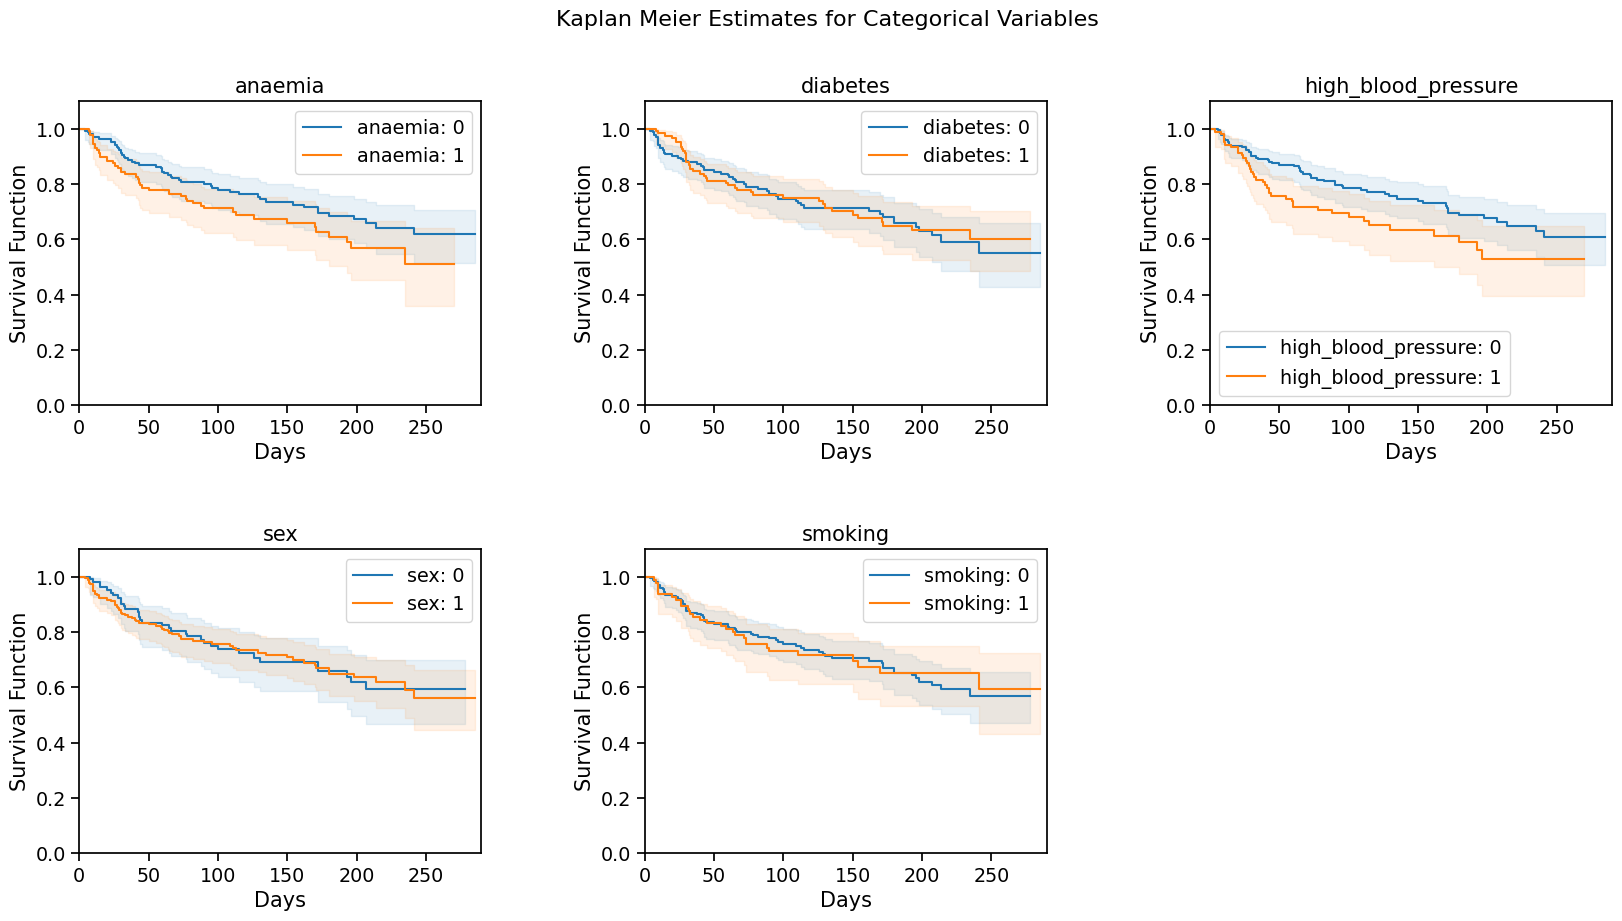

In [34]:
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(18,10))
plt.tight_layout(pad=5.0)

for i,feat in enumerate(categorical_cols.drop('died',axis=1).columns):
    cat_fits = km_fits(df, hue=feat)

    [x.plot(title=feat, ylabel="Survival Function", xlabel="Days",
            ylim=(0,1.1), xlim=(0,290),
            ci_alpha=0.1, ax=ax.flatten()[i]) for x in cat_fits]

ax.flatten()[-1].set_visible(False)
fig.suptitle("Kaplan Meier Estimates for Categorical Variables ", fontsize=16.0)
plt.show()

#### Numerical Columns

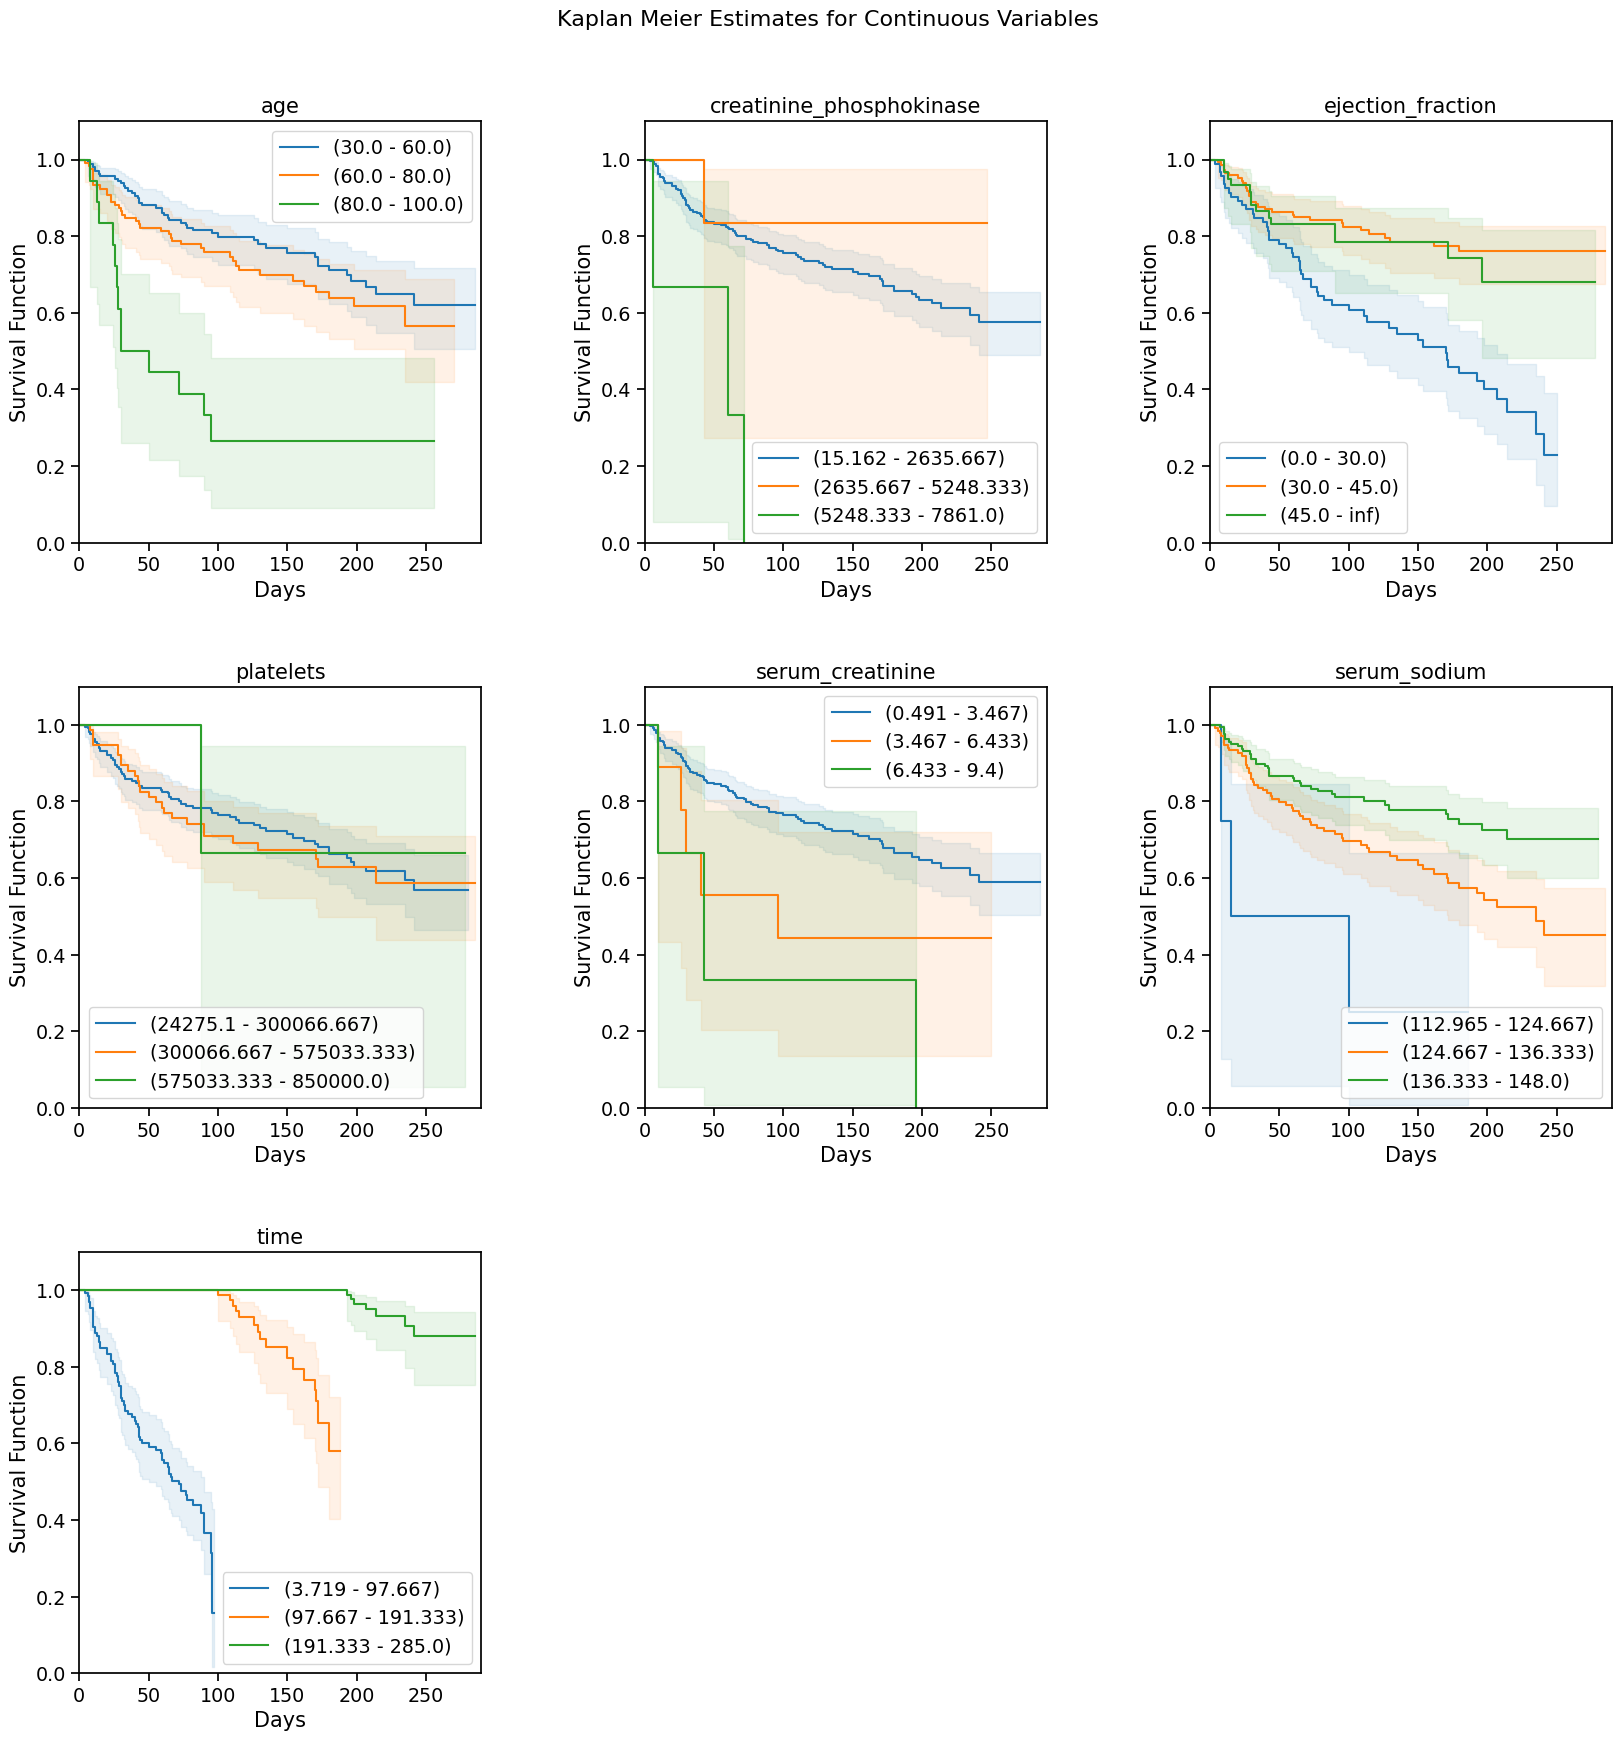

In [35]:
fig, ax = plt.subplots(nrows=3, ncols=3, figsize=(18,18))

plt.tight_layout(pad=5.0)

split_points = [[30.0,60.0,80.0,100.0],3,[0,30.0,45.0,np.inf],3,3,3,3]

for i,feat in enumerate(numerical_cols.columns):
    con_fits = km_fits(df, hue=feat,split_points=split_points[i])

    [x.plot(title=feat, ylabel="Survival Function", xlabel="Days",
            ylim=(0,1.1), xlim=(0,290), ci_alpha=0.1, 
            ax=ax.flatten()[i]) for x in con_fits]

ax.flatten()[-1].set_visible(False)
ax.flatten()[-2].set_visible(False)

fig.suptitle("Kaplan Meier Estimates for Continuous Variables ", fontsize=16.0, y=1.0)

plt.show()

### We can even reproduce the figures from the original manuscript _(Ahmad et al. 2017)_ to validate our methods. <br>
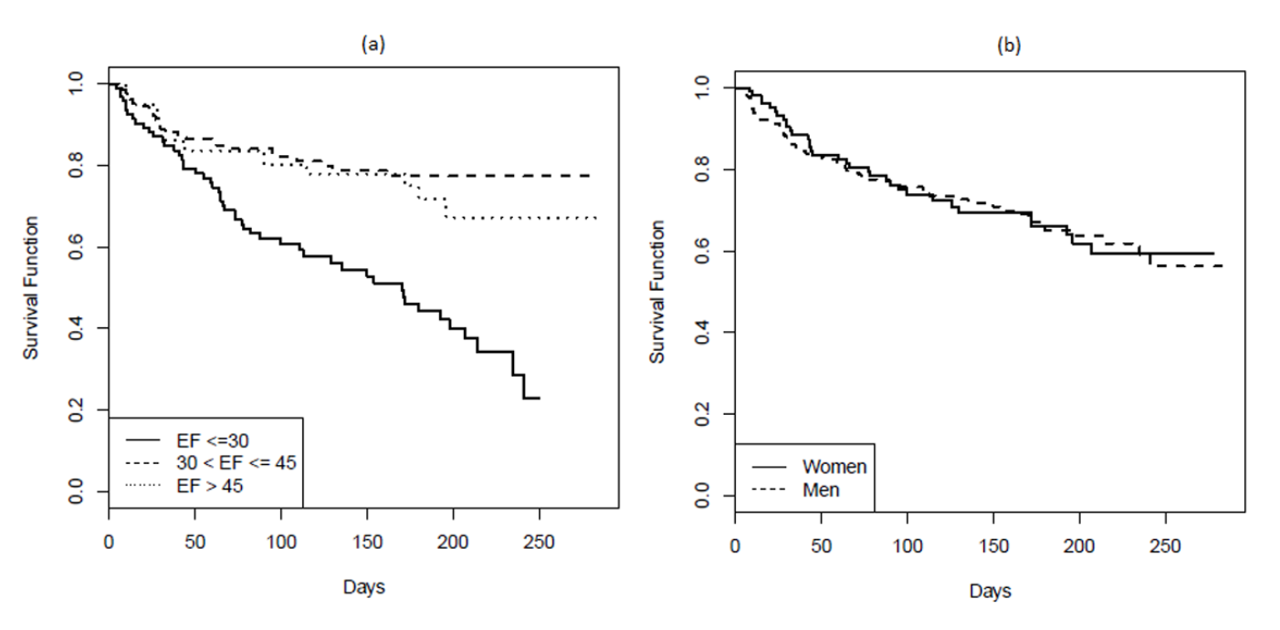

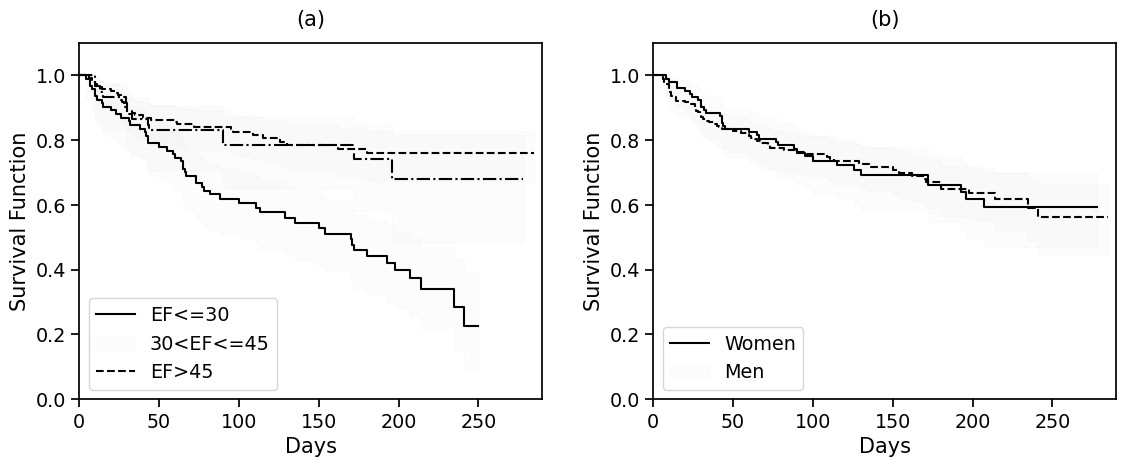

In [38]:
EF_fits = km_fits(df, hue="ejection_fraction",split_points=[0,30.0,45.0,np.inf])
sex_fits = km_fits(df, hue="sex")

styles=['-','--','-.']

fix, ax = plt.subplots(1,2, figsize=(12,5))
plt.tight_layout(pad=2.5)

[x0.plot(kind='line',ax=ax[0], ci_alpha=0.01, xlabel="Days", ylabel="Survival Function",
         color='k', xlim=(0,290), ylim=(0,1.1), style=styles[i]) for i,x0 in enumerate(EF_fits)]

[x1.plot(kind='line',ax=ax[1], ci_alpha=0.01, xlabel="Days", ylabel="Survival Function", 
         color='k', xlim=(0,290), ylim=(0,1.1), style=styles[j]) for j,x1 in enumerate(sex_fits)]

ax[0].legend(loc=3, labels=['EF<=30', '30<EF<=45','EF>45'])
ax[1].legend(loc=3, labels=['Women','Men'])
ax[0].set_title('(a)', y=1.025)
ax[1].set_title('(b)', y=1.025)
plt.show()

_____________
## Insights from the EDA <br>
### Categorical Data: 
- Those with **high blood pressure** have an **increased risk of death**. This is reasonable as hypertension is a major risk factor for heart failure _(Levy D, Larson MG, Vasan RS, Kannel WB, Ho KKL. The Progression From Hypertension to Congestive Heart Failure. JAMA. 1996;275(20):1557–1562. doi:10.1001/jama.1996.03530440037034)_.
- **Anaemia** is associated with **increased risk of death**. Again, this is reasonable as anaemia is a common comorbidity of heart failure _(Shah R, Agarwal AK. Anemia associated with chronic heart failure: current concepts. Clin Interv Aging. 2013;8:111-122. doi:10.2147/CIA.S27105)_ 
- However, as demonstrated in the Kaplan Meier curves, hypertension and anaemia do carry increased risk of death but the confidence intervals are wide enough that these are not statistically significant. <br>


### Numerical Data: 
- A low value for **time** is **highly correlated with death**. This is due to the follow up period being cut short due to death of the patient. It is obvious however, that the number of days is not what killed the patient (other than the relentless and inevitable march of time), it is merely that the number of days are cut short in those who were lost to follow up due to death. In this sense time is not a clinically useful variable for screening patients e.g <br> _Doctor: "Go home, and if you don't come back in 3 months theres a good chance you have died"._ **More on time later in this notebook.**
- A lower **ejection fraction** seems to have some correlation with **increased death**. This seems reasonable as typically a low stroke volume is associated with congestinve heart failure. Stroke volume, along with end diastolic volume make up the equation for ejection fraction. $ EF = {SV/EDV} $ Where EF is the ejection fraction, SV is the stroke volume, EDV is the end diastolic volume. 
- **Increased age** appears to play a slight role in **increased death**. 
- Elevated **serum_creatinine** appears to indicate **inreased death**
- Creatinine_phosphokinase, platelets, and serum_sodium do **not** appear to have any significant influence in predicting patient outcome
<br>

### Survival Analysis
- The predictive power of the ejection fraction is shown very well through the use of the Kaplan Meier curves.
- As expected, age also shows a strong correlation with survival, as made apparent through the Kaplan Meier curves.
- Serum creatinine is also strongly correlated with survival, however the confidence intervals are quite wide.
_______
**Note**: This dataset comes from the paper _Machine learning can predict survival of patients with heart failure from serum creatinine and ejection fraction alone_ (Chicco & Jurman, 2020) which took the dataset from this original study _Survival analysis of heart failure patients: A cases tudy_ (Ahmad et al. 2017). Therefore, we know _a priori_ that ejection fraction and creatinine alone are likely the two most important features. However, feature importance varies across models, therefore, independant analysis of feature importance is still required. https://doi.org/10.1186/s12911-020-1023-5
_______




# Data Cleaning

### Correcting
Check data for any obvious errors such as age=650 <br>

In [37]:
numerical_cols.describe().loc(axis=0)['min','max']

KeyError: 'max'

Some quick googling tells me the ranges below are all within a physiological or pathophysiological range so there is no reason to suspect any incorrect data.

### Completing <br>
Check for any missing values or NaNs in the data.

In [39]:
df.isnull().any()

age                         False
anaemia                     False
creatinine_phosphokinase    False
diabetes                    False
ejection_fraction           False
high_blood_pressure         False
platelets                   False
serum_creatinine            False
serum_sodium                False
sex                         False
smoking                     False
time                        False
died                        False
dtype: bool

There are no NaNs or empty values in the dataset.

### Creating <br>
No new features will be created in this iteration. Performance will be measured with the original feature set.

### Converting 
* All of the categorical data is binary in nature so there is no need for one-hot encoding. 
* Features will be scaled in the modelling section below.


### Feature Correlation

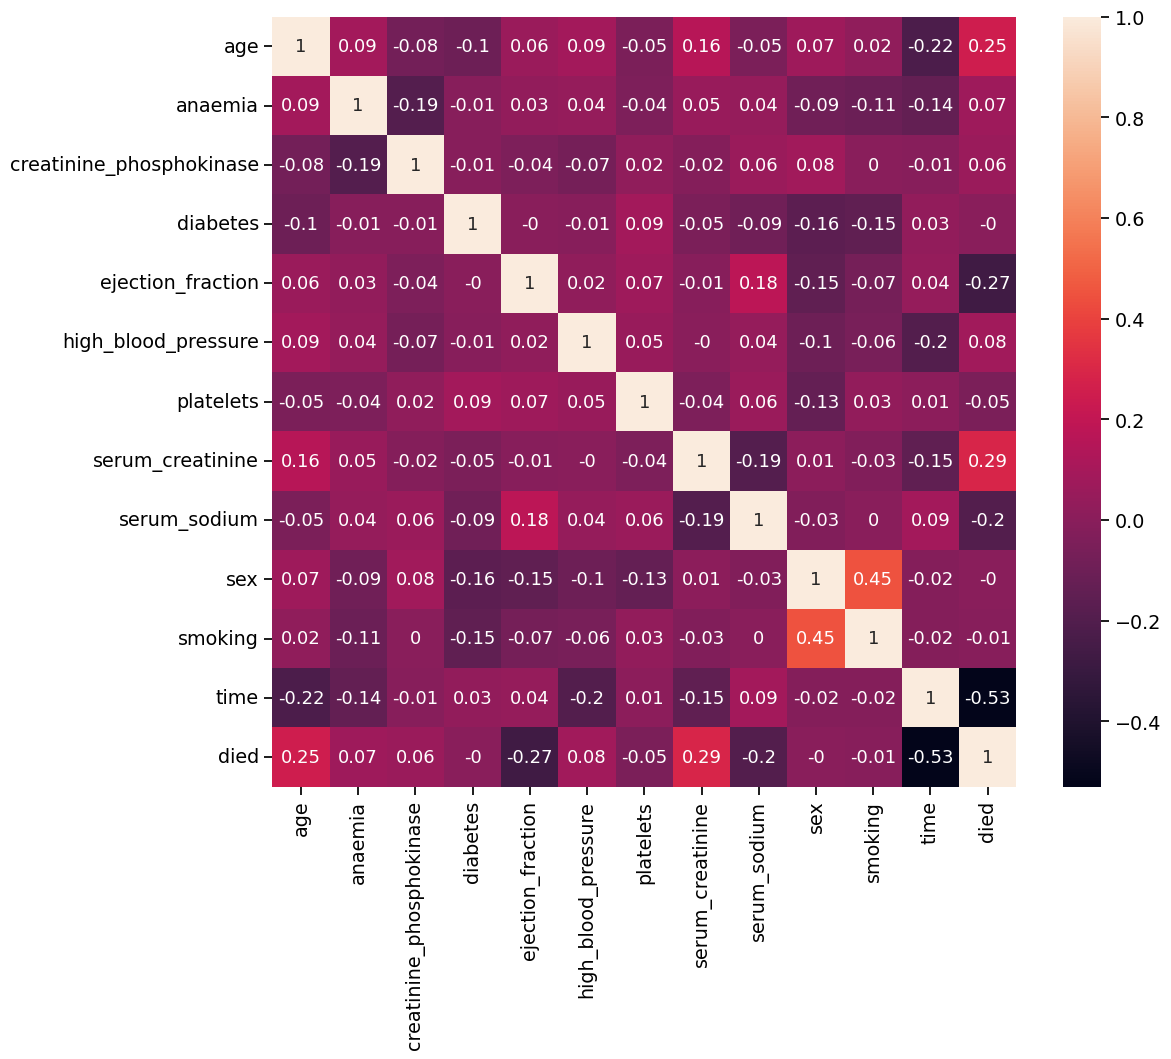

In [40]:
plt.figure(figsize=(12,10))
fig = sns.heatmap(data=round(df.corr(),2), annot=True, annot_kws={"fontsize":13})
plt.show()

# Modelling
## Feature Scaling

In [41]:
scaler = StandardScaler()

df_scaled = df.copy()
df_scaled.loc(axis=1)[numerical_cols.columns] = scaler.fit_transform(df.loc(axis=1)[numerical_cols.columns]) 

/var/folders/42/gncpdw1n5jx_vgps1gq5mzf00000gn/T/ipykernel_63970/789293186.py:4: FutureWarning:

Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value '[ 1.65728387e-04  7.51463953e+00 -4.49938761e-01 -4.86071002e-01
 -4.35485864e-01 -5.52141386e-01 -3.46703786e-01 -2.75471654e-01
 -4.38582914e-01 -4.73682805e-01 -5.17041494e-01 -3.62189032e-01
  4.12073277e-01 -4.27227066e-01 -5.18073844e-01 -2.09401270e-01
 -4.46841712e-01  1.65728387e-04 -4.71618105e-01  1.65728387e-04
 -5.46979637e-01 -4.68521056e-01 -3.73544880e-01 -5.35623790e-01
  1.65728387e-04 -4.47874061e-01 -4.85038652e-01 -4.74715155e-01
 -5.38720839e-01 -5.28397342e-01  1.65728387e-04 -5.76917780e-01
 -3.43606737e-01 -4.36518214e-01 -5.03620948e-01  1.65728387e-04
 -5.38720839e-01  2.81997209e-01  2.14125910e+00 -3.58059633e-01
  1.65728387e-04 -4.72650455e-01 -1.11901188e-02 -4.69553406e-01
  6.35982686e-03  1.65728387e-04  8.23980826e-01  1.65728387e-04
 -2.97724142e-02 -4.

## Model comparison & Leakage comparison using Repeated Stratified K-Fold Cross Validation

In [42]:
RANDOM_STATE = 2

cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=RANDOM_STATE)

feat_set = ['Leakage', 'Baseline']

# create list of models to evaluate
models = [LogisticRegression(), 
          RandomForestClassifier(random_state=RANDOM_STATE), 
          XGBClassifier(verbosity=0, use_label_encoder = False, 
                        random_state=RANDOM_STATE, eval_metric='logloss'),
          GradientBoostingClassifier(random_state=RANDOM_STATE),
          SVC(kernel='sigmoid'),
          QuadraticDiscriminantAnalysis()]

model_names = [mod.__class__.__name__ for mod in models]

mod_cols = ['Name', 
            'Parameters',
            'Time']

df_mod = pd.DataFrame(columns=mod_cols)

for i in range(len(feat_set)):

    # Features
    
    if (i==0):
        X = df_scaled.drop('died',axis=1)
    else:
        X = df_scaled.drop(['time','died'],axis=1)

     
    y = df_scaled['died']
    
    for j,model in enumerate(models):

        # evaluate model
        cv_results = cross_validate(model, X, y, cv=cv, scoring="f1", return_train_score = True)
        df_mod.loc[j + len(models)*i , 'Parameters'] = str(model.get_params())
        df_mod.loc[j + len(models)*i, 'Name'] = model.__class__.__name__
        df_mod.loc[j + len(models)*i, 'Time'] = cv_results['fit_time'].mean()
        df_mod.loc[j + len(models)*i, 'Train Accuracy'] = cv_results['train_score'].mean()
        df_mod.loc[j + len(models)*i, 'Test Score'] = cv_results['test_score'].mean()
        df_mod.loc[j + len(models)*i, 'feat_set'] = feat_set[i]
    

In [46]:
for i in range(len(feat_set)):

    # 1. Features festlegen (X) und Zielvariable (y)
    if (i == 0):
        # Szenario: Leakage
        X = df_scaled.drop('died', axis=1)
    else:
        # Szenario: Baseline
        X = df_scaled.drop(['time', 'died'], axis=1)

    y = df_scaled['died']
    
    # 2. Den kompletten Datensatz für dieses Szenario zusammenführen und speichern
    # Wir hängen y ('died') wieder an X an
    df_full_scenario = X.copy()
    df_full_scenario['died'] = y
    
    # Dateiname basierend auf dem feat_set (Leakage oder Baseline)
    filename = f"heart_failure_clinical_records_dataset_{feat_set[i].lower()}.csv"
    df_full_scenario.to_csv(filename, index=False)
    
    print(f"Datei gespeichert: {filename}")

    # 3. Modell-Evaluierung (Cross-Validation)
    for j, model in enumerate(models):
        cv_results = cross_validate(model, X, y, cv=cv, scoring="f1", return_train_score=True)
        
        row_idx = j + len(models) * i
        df_mod.loc[row_idx, 'Parameters'] = str(model.get_params())
        df_mod.loc[row_idx, 'Name'] = model.__class__.__name__
        df_mod.loc[row_idx, 'Time'] = cv_results['fit_time'].mean()
        df_mod.loc[row_idx, 'Train Accuracy'] = cv_results['train_score'].mean()
        df_mod.loc[row_idx, 'Test Score'] = cv_results['test_score'].mean()
        df_mod.loc[row_idx, 'feat_set'] = feat_set[i]

Datei gespeichert: heart_failure_clinical_records_dataset_leakage.csv
Datei gespeichert: heart_failure_clinical_records_dataset_baseline.csv


In [43]:
df_mod.loc(axis=1)['Name','Train Accuracy','Test Score','feat_set'].sort_values('Test Score', ascending=False)

,Name,Train Accuracy,Test Score,feat_set
1,RandomForestClassifier,1.000000,0.735710,Leakage
2,XGBClassifier,1.000000,0.734747,Leakage
4,SVC,0.676040,0.724766,Leakage
3,GradientBoostingClassifier,0.998645,0.720331,Leakage
0,LogisticRegression,0.751570,0.716109,Leakage
7,RandomForestClassifier,1.000000,0.536512,Baseline
9,GradientBoostingClassifier,0.938224,0.536325,Baseline
8,XGBClassifier,1.000000,0.531172,Baseline
5,QuadraticDiscriminantAnalysis,0.649007,0.518583,Leakage
6,LogisticRegression,0.565785,0.513658,Baseline


In [44]:
fig = px.bar(data_frame = df_mod.sort_values('Test Score', ascending=True),
             x="Name", y="Test Score", color="feat_set", barmode="group",
             color_discrete_sequence=px.colors.qualitative.D3,
             template = "plotly_white")
fig.show()

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

________
### **IMPORTANT NOTE REGARDING TARGET LEAKAGE:**

The barplot above highlights the importance of **correct feature selection**. Time cannot be a feature of the model because it is **not available at the time of prediction**. The **time variable is a direct result of the death event** so to use the time variable in the model would introduce **target leakage**. <br>
A concrete example would be as follows: A patient comes to you hoping to receive a heart failure prediction using your model. You say: "sure" and collect their data to make a prediction. However, you come to the time column, what do you put here? Number of days since... when? The model we build must be useful and accurate, therefore **we cannot use time as a feature.**
________

### XGBoost, Random Forest, and Gradient Boost are the most accurate classifiers for this data using default hyperparameters. <br>
__Moving forward I will only consider these models.__
<br>


## Using Synthetic Minority Oversampling TEchnique (SMOTE) to improve the imbalanced dataset

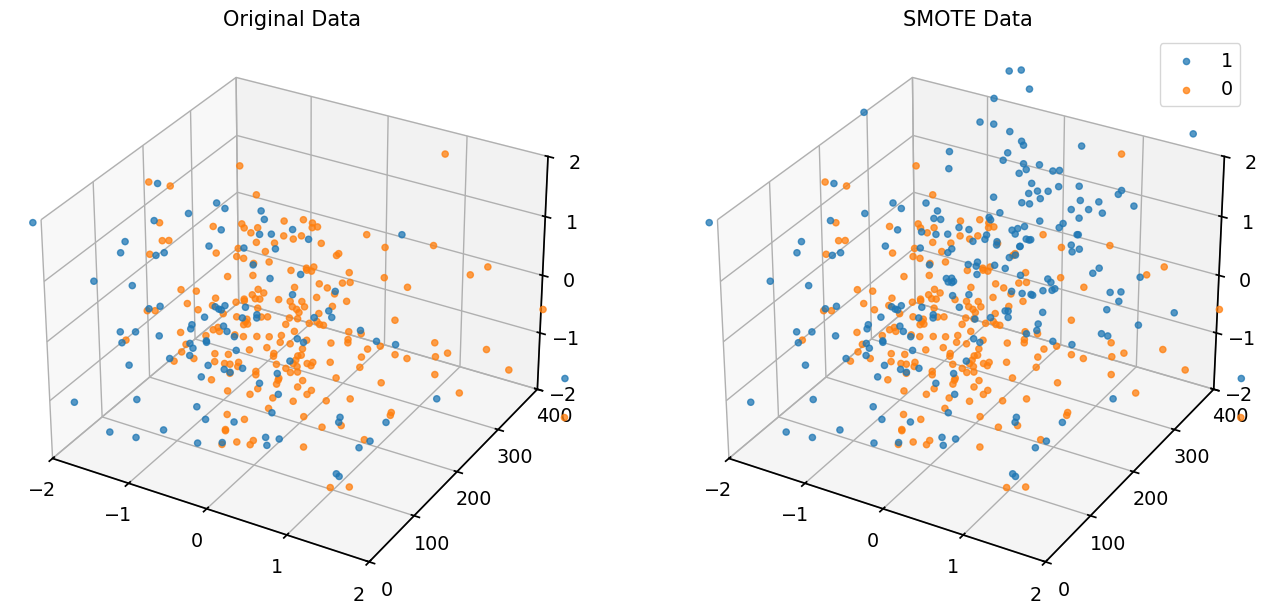

In [45]:
counter = Counter(y) 

# transform the dataset
oversample = SMOTE()
X_sm, y_sm = oversample.fit_resample(X, y)
df_sm = X_sm.copy()
df_sm['died'] = y_sm
smote_counter = Counter(y_sm)

## Visualise the oversampling ## 
fig = plt.figure(figsize=(16,8))
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2, projection='3d')
ax = [ax1, ax2]
for label, _ in counter.items():
    row_ix = np.where(y == label)[0]
    ax1.scatter(X.loc(axis=0)[row_ix]["platelets"],
                    [row_ix], 
                    X.loc(axis=0)[row_ix]["age"],
                    label=str(label),
                    alpha=0.75)
                    
for label_sm, _ in smote_counter.items():
    row_ix_sm = np.where(y_sm == label_sm)[0]
    ax2.scatter(X_sm.loc(axis=0)[row_ix_sm]["platelets"], 
                    [row_ix_sm],
                    X_sm.loc(axis=0)[row_ix_sm]["age"],
                    label=str(label_sm), alpha=0.75)

for axi in ax:
    axi.set_zlim(-2,2)
    axi.set_xlim(-2,2)
    axi.set_ylim(0,400)
    axi.set_xticks([-2,-1,0,1,2])
    axi.set_yticks([0,100,200,300,400])
    axi.set_zticks([-2,-1,0,1,2])
    
ax1.set_title("Original Data")
ax2.set_title("SMOTE Data")
plt.legend()
plt.show()

### Evaluate the impact of SMOTE on the models

In [ ]:
df_mod_sm = df_mod.copy()

for model in models:

    cv_results = cross_validate(model, X_sm, y_sm, cv=cv, scoring="f1", return_train_score = True)
    
    # Adding 1 to the max index instead of appending so I can pass everything as a dict()
    df_mod_sm.loc(axis=0)[df_mod_sm.index.values.max()+1] = {
            'Name':model.__class__.__name__,
            'Parameters':str(model.get_params()),
            'Time':cv_results['fit_time'].mean(),
            'Train Accuracy':cv_results['train_score'].mean(),
            'Test Score':cv_results['test_score'].mean(),
            'feat_set':'SMOTE'
             }

In [ ]:
fig = px.bar(data_frame = df_mod_sm.sort_values('Test Score', ascending=True),
             x="Name", y="Test Score", color="feat_set", barmode="group",
             color_discrete_sequence=px.colors.qualitative.D3,
             template = "plotly_white")
fig.show()

### The original research article had an F1 score of 0.547 using the Random Forest, this is close to the F1 score of our Random Forest. <br> Lets see if we can improve the result!

## Determine Feature Importance

Selecting appropriate features can result in improvements in model metrics through eliminating noisy features. It has the added benefit of making the model easier to understand and more explainable. 

### Feature importance using permutation feature importance:

In [ ]:
top_model_names = df_mod_sm.sort_values('feat_set', ascending=False).sort_values('Test Score', ascending=False)['Name'][:3].values
top_models = [m for m in models if m.__class__.__name__ in top_model_names]

# Initialize a DataFrame to contain the importances of each feature for each model
df_imp = pd.DataFrame(index=range(0,len(X_sm.columns)*len(top_models)), columns=['feature','model','importance'])

# len_feat will allow us to populate the features for each model
len_feat = int(len(X_sm.columns))

for i in range(len(top_models)):
    results = permutation_importance(top_models[i].fit(X_sm, y_sm), X_sm, y_sm, scoring="f1", 
                                n_repeats=10, n_jobs=None, 
                                random_state=RANDOM_STATE)   
    df_imp.loc[range(len_feat*i,len_feat*(i+1)),'importance'] = (results['importances_mean'])
    df_imp.loc[range(len_feat*i,len_feat*(i+1)),'model'] = top_models[i].__class__.__name__
    df_imp.loc[range(len_feat*i,len_feat*(i+1)),'feature'] = X_sm.columns

In [ ]:
fig = px.bar(data_frame=df_imp.sort_values('importance'), 
             x="importance", 
             y="feature", 
             color="model",
             barmode="group",
             orientation="h",
             template = "plotly_white"
             )
fig.show()

### Feature importance using SHAP (SHapley Additive exPlanations):

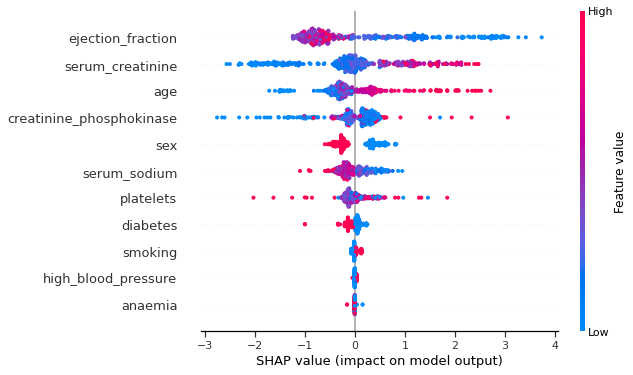

In [ ]:
shap.initjs()
explainer = shap.TreeExplainer(top_models[2].fit(X_sm, y_sm))
shap_values = explainer.shap_values(X_sm)
shap.summary_plot(shap_values, features=X_sm, feature_names=X_sm.columns)

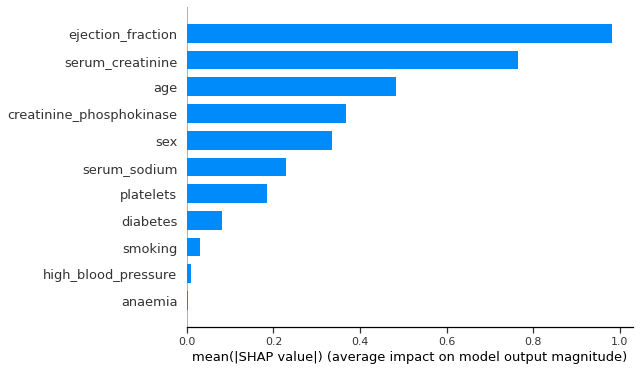

In [ ]:
shap.summary_plot(shap_values, features=X_sm, 
                        feature_names=X_sm.columns, 
                        plot_type="bar")

* Clearly **_high_blood_pressure_, _smoking_, _diabetes_, _anaemia_ are the least important features** across both methods of determining feature importance (permutation & SHAP).
* **These will be dropped** from the analysis and the resultant change in performance will be noted.

### Run the models using 2 feature sets: 
* **mean absolute SHAP value >0.1**  
* **mean absolute SHAP value >0.6**

In [ ]:
feats = []

df_mod_sm_f = df_mod_sm[df_mod_sm['Name'].isin(top_model_names)].copy()

for j in [1,6]:
    feats.append(X_sm.columns[np.argsort(np.abs(shap_values).mean(0))][::-1][:j+1].values)

for i,feat in enumerate(feats):    
    for model in top_models:
        cv_results = cross_validate(model, X_sm.loc(axis=1)[feat], y_sm, cv=cv, 
                                    scoring="f1", return_train_score = True)

        # Adding 1 to the max index instead of appending so I can pass everything as a dict()
        df_mod_sm_f.loc(axis=0)[df_mod_sm_f.index.values.max()+1] = {
                'Name':model.__class__.__name__,
                'Parameters':str(model.get_params()),
                'Time':cv_results['fit_time'].mean(),
                'Train Accuracy':cv_results['train_score'].mean(),
                'Test Score':cv_results['test_score'].mean(),
                'feat_set': f"SMOTE {len(feat)}-Feature"
                 }

In [ ]:
fig = px.bar(data_frame = df_mod_sm_f.sort_values('Test Score', ascending=True),
             x="Name", y="Test Score", color="feat_set", barmode="group",
             color_discrete_sequence=px.colors.qualitative.D3,
             template = "plotly_white")
fig.show()

* A similar F1 score is achieved using only 7 of the original features compared to the full set of features. 
* Using only 2 features results in a marginal decrease in the F1 score compared to using 7 features.

### Random Forest Classifier Hyperparameter Tuning using Grid Search

In [ ]:
rf_param_space = {"n_estimators" : [2000, 5000],
                  "criterion":["gini"], 
                  "max_depth":[9, 18],
                  "min_samples_split": [2, 6]}

random_forest = RandomForestClassifier(random_state=RANDOM_STATE)

rf_gscv = HalvingGridSearchCV(estimator=random_forest, param_grid=rf_param_space,
                   cv = 10, scoring = "f1", n_jobs = -1,verbose = 1, random_state=RANDOM_STATE)

# rf_gscv = GridSearchCV(estimator=random_forest, param_grid=rf_param_space,
#                    cv = cv, n_jobs=-1, scoring = "f1", verbose = 1)

print('Running GridSearchCV for Random Forest Classifier...')
rf_gscv.fit(X_sm.loc(axis=1)[feats[1]], y_sm)

print("best estimator: ", rf_gscv.best_estimator_)
print("best parameters: ", rf_gscv.best_params_)
print("best score: ",rf_gscv.best_score_)

Running GridSearchCV for Random Forest Classifier...
n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 2
min_resources_: 135
max_resources_: 406
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 8
n_resources: 135
Fitting 10 folds for each of 8 candidates, totalling 80 fits
----------
iter: 1
n_candidates: 3
n_resources: 405
Fitting 10 folds for each of 3 candidates, totalling 30 fits
best estimator:  RandomForestClassifier(max_depth=18, min_samples_split=6, n_estimators=5000,
                       random_state=2)
best parameters:  {'criterion': 'gini', 'max_depth': 18, 'min_samples_split': 6, 'n_estimators': 5000}
best score:  0.8239038213649913


### Gradient Boosing Classifier Hyperparameter Tuning using Grid Search

In [ ]:
gb_param_space = {"n_estimators" : [1000, 2500],
                  "subsample" : [0.5, 1.0],
                  "max_depth":[9, 18],
                  "learning_rate" : [0.025, 0.75]}

grad_boost = GradientBoostingClassifier(random_state=RANDOM_STATE)

gb_gscv = HalvingGridSearchCV(estimator=grad_boost, param_grid=gb_param_space,
                   cv = 10, scoring = "f1", n_jobs = -1,verbose = 1, random_state=RANDOM_STATE)

# gb_gscv = GridSearchCV(estimator=grad_boost, param_grid=gb_param_space,
#                    cv = cv, n_jobs=-1, scoring = "f1", verbose = 1)

print('Running GridSearchCV for Gradient Boosting Classifier...')
gb_gscv.fit(X_sm.loc(axis=1)[feats[1]], y_sm)

print("best estimator: ", gb_gscv.best_estimator_)
print("best parameters: ", gb_gscv.best_params_)
print("best score: ", gb_gscv.best_score_)

Running GridSearchCV for Gradient Boosting Classifier...
n_iterations: 3
n_required_iterations: 3
n_possible_iterations: 3
min_resources_: 45
max_resources_: 406
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 16
n_resources: 45
Fitting 10 folds for each of 16 candidates, totalling 160 fits
----------
iter: 1
n_candidates: 6
n_resources: 135
Fitting 10 folds for each of 6 candidates, totalling 60 fits
----------
iter: 2
n_candidates: 2
n_resources: 405
Fitting 10 folds for each of 2 candidates, totalling 20 fits
best estimator:  GradientBoostingClassifier(learning_rate=0.75, max_depth=9, n_estimators=1000,
                           random_state=2)
best parameters:  {'learning_rate': 0.75, 'max_depth': 9, 'n_estimators': 1000, 'subsample': 1.0}
best score:  0.8196479225671393


### XGBoost Hyperparameter using Grid Search
Hyperparameter tuning for XGBoost was inhibitively slow and resulted in a decrease in F1 score. Therefore, default hyperparameters are used and the .fit statement in the code below in commented out.

In [ ]:
xgb_param_space = {"n_estimators":[100, 500],
                   "subsample" : [0.5, 1.0],
                   "max_depth" : [9, 18],
                   "eta" : [0.25, 0.75]}

xgboost = XGBClassifier(use_label_encoder=False, random_state=RANDOM_STATE, eval_metric='logloss')

# xgb_gscv = HalvingGridSearchCV(estimator=xgboost, param_grid=xgb_param_space,
#                    cv = cv, scoring = "f1", n_jobs = -1,verbose = 1, random_state=RANDOM_STATE)

xgb_gscv = GridSearchCV(estimator=xgboost, param_grid=xgb_param_space,
                   cv = 10, n_jobs=-1, scoring = "f1", verbose = 1)

# ------- Uncomment code below to run grid search for XGBoost -------
# print('Running GridSearchCV for XGBoost Classifier...')
# xgb_gscv.fit(X_sm.loc(axis=1)[feats[1]], y_sm)

# print("best estimator: ", xgb_gscv.best_estimator_)
# print("best parameters: ", xgb_gscv.best_params_)
# print("best score: ", xgb_gscv.best_score_)

# xgb_gscv.best_params_['use_label_encoder'] = False
# xgb_gscv.best_params_['eval_metric'] = 'logloss'
# xgb_gscv.best_params_['random_state'] = RANDOM_STATE
# tuned_xgb = XGBClassifier(**xgb_gscv.best_params_)

In [ ]:
rf_gscv.best_params_['random_state'] = RANDOM_STATE
gb_gscv.best_params_['random_state'] = RANDOM_STATE

tuned_rf = RandomForestClassifier(**rf_gscv.best_params_)
tuned_gb = GradientBoostingClassifier(**gb_gscv.best_params_)
tuned_xgb = XGBClassifier(verbosity=0, use_label_encoder = False, 
                        random_state=RANDOM_STATE, eval_metric='logloss')

tuned_models = [tuned_rf, tuned_gb, tuned_xgb] 

df_final = pd.DataFrame(index = range(len(tuned_models)) ,
                        columns = ['Name',
                                   'Parameters',
                                   'Time', 
                                   'F1 Score', 
                                   'Precision', 
                                   'Recall',
                                   'Accuracy',
                                   'roc_auc',
                                   'fpr',
                                   'tpr'
                                  ])

for i, model in enumerate(tuned_models):
    cv_results = cross_validate(model, X_sm.loc(axis=1)[feats[1]], y_sm, cv=cv, 
                                scoring=["f1", "precision", "recall", "roc_auc", "accuracy"],
                                return_train_score = True)

    # Adding 1 to the max index instead of appending so I can pass everything as a dict()
    df_mod_sm_f.loc(axis=0)[df_mod_sm_f.index.values.max()+1] = {
            'Name':model.__class__.__name__,
            'Parameters':str(model.get_params()),
            'Time':cv_results['fit_time'].mean(),
            'Train Accuracy':cv_results['train_accuracy'].mean(),
            'Test Score':cv_results['test_f1'].mean(),
            'feat_set': f"SMOTE {len(feats[1])}-Feature (Tuned)"
             }
    
    # Gather data needed for ROC Curves
    y_pred = cross_val_predict(model, X_sm.loc(axis=1)[feats[1]], y_sm, cv=10, method='predict_proba')  
    fpr, tpr, thresholds = roc_curve(y_sm, y_pred[:,1])
    roc_auc = auc(fpr, tpr)
    
    # Adding 1 to the max index instead of appending so everything can pass as a dict()
    df_final.loc(axis=0)[i] = {
            'Name':model.__class__.__name__,
            'Parameters':str(model.get_params()),
            'Time':cv_results['fit_time'].mean(),            
            'F1 Score':cv_results['test_f1'].mean(),
            'Precision':cv_results['test_precision'].mean(),
            'Recall':cv_results['test_recall'].mean(),
            'Accuracy':cv_results['test_accuracy'].mean(),
            'roc_auc':roc_auc,
            'fpr':fpr,
            'tpr':tpr
             }

In [ ]:
fig = px.bar(data_frame = df_mod_sm_f.sort_values('Test Score', ascending=True),
             x="Name", y="Test Score", color="feat_set", barmode="group",
             color_discrete_sequence=px.colors.qualitative.D3,
             template = "plotly_white")
fig.show()

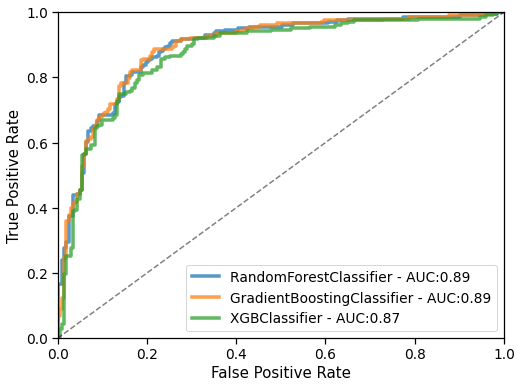

In [ ]:
lw=3.5
plt.figure(figsize=(8,6))

[plt.plot(df_final['fpr'][i], df_final['tpr'][i], 
          label = f"{df_final['Name'][i]} - AUC:{df_final['roc_auc'][i]:.2f}",
          linewidth=lw, alpha=0.75) for i in range(len(df_final))]

plt.plot([0,1],[0,1],'--k', alpha=0.5)
plt.xlim(0,1)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.ylim(0,1)
plt.legend()
plt.show()

In [ ]:
df_final_melt = df_final.melt(value_vars = [
    "F1 Score", 
    "Precision", 
    "Recall", 
    "roc_auc", 
    "Accuracy"], id_vars="Name")

fig = px.bar(data_frame = df_final_melt.sort_values('value', ascending=True),
             x="variable", y="value", color="Name", barmode="group",
             color_discrete_sequence=px.colors.qualitative.Plotly,
             template = "plotly_white")
fig.show()

## ...and the winner is!
**RandomForestClassifier**
* The clinical application of this model means it should be optimised to **minimize the number of false negatives predictions** and the best metric to go by in that respect is Recall (TP / TP + FN). **Recall is highest in the RandomForestClassifier**. 
* Every other metric is also highest in the RandomForestClassifier

# Conclusion
* **SMOTE** significantly improved the dataset which resulted in much **higher performance** from the model.
* **Hyperparameter tuning** resulted in very modest improvements and takes far more time than SMOTE.
* **Feature selection** simplified the model whilst maintaining performance, what's not to love?

# If you liked this Kernel please consider giving it an upvote.
## I would love to hear any feedback you have about anything in the Kernel, questions, suggestions for improvements, leave a comment!